In [131]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [132]:
#### Preprocecing ###

In [133]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")

In [134]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [135]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [136]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]

In [137]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]

In [138]:
removed = recovered + death

In [139]:
### Data Preparation ###

In [140]:
S = confirmed.values
R = removed.values

In [141]:
data = {'T': S.shape[0], 'N': S.shape[1], 'S': S, 'R': R}

In [142]:
### Model ###

In [143]:
sm = pystan.StanModel(file="covid19.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7bb6dcc44e91d0621be4d7e15163d949 NOW.


In [144]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [145]:
### Simulation and Visualization functions ###

In [146]:
T = S.shape[0]
N = S.shape[1]

In [147]:
def simulate(a, p, c, sigma_S, sigma_R, start, horizen):
    cumulative = confirmed.loc[start].values
    recovered = removed.loc[start].values
    infected_list = []
    for d in range(horizen):
        infected_list.append(cumulative - recovered)
        cumulative0 = cumulative
        I = (cumulative - recovered) @ c * (1 - cumulative / p) + np.sqrt(sigma_S) * np.random.randn(N)
        cumulative = cumulative + np.maximum(I, 0)
        recovered = recovered + a * (cumulative0 - recovered) + np.sqrt(sigma_R) * np.random.randn(N)
        recovered = np.clip(recovered, 0, cumulative)
        
    infected = pd.DataFrame(infected_list, 
                            columns=confirmed.columns,
                            index=pd.date_range(start, periods=horizen, freq='D'))
    return infected

In [148]:
def draw_infected(fit, start, horizen, country):
    a = fit['a']
    p = fit['p']
    c = fit['c']
    sigma_S = fit['sigma_S']
    sigma_R = fit['sigma_R']
    np.random.shuffle(a)
    np.random.shuffle(p)
    np.random.shuffle(c)
    np.random.shuffle(sigma_S)
    np.random.shuffle(sigma_R)
    data = pd.DataFrame()
    for i in range(a.shape[0]):
        infected = simulate(a[i], p[i], c[i], sigma_S[i], sigma_R[i], start, horizen)
        data = pd.concat([data, infected[country]], axis=1)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed)[country]
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);

In [149]:
### Validation ###

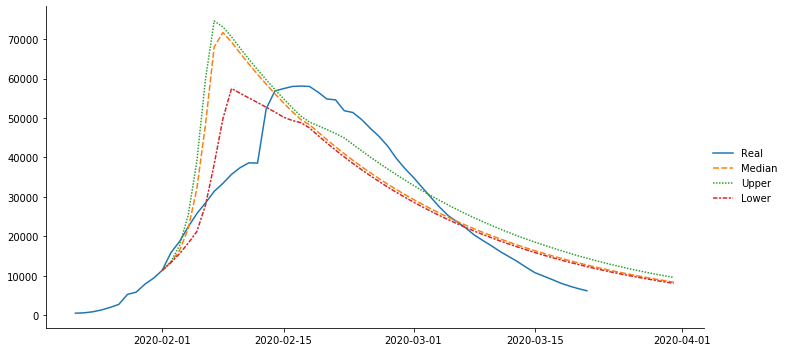

In [150]:
draw_infected(fit, pd.to_datetime('2020-02-01'), 60, 'China')

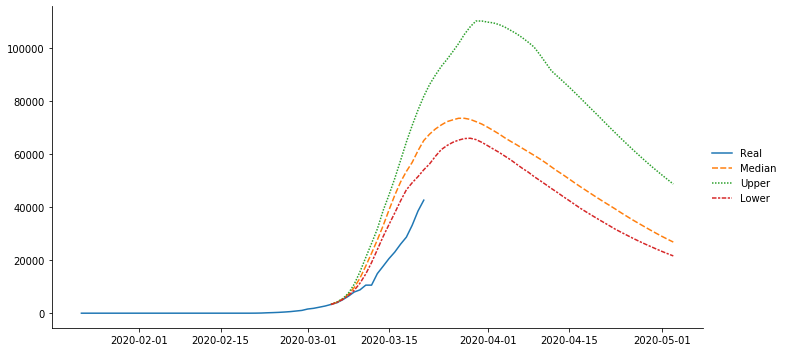

In [151]:
draw_infected(fit, pd.to_datetime('2020-03-5'), 60, 'Italy')

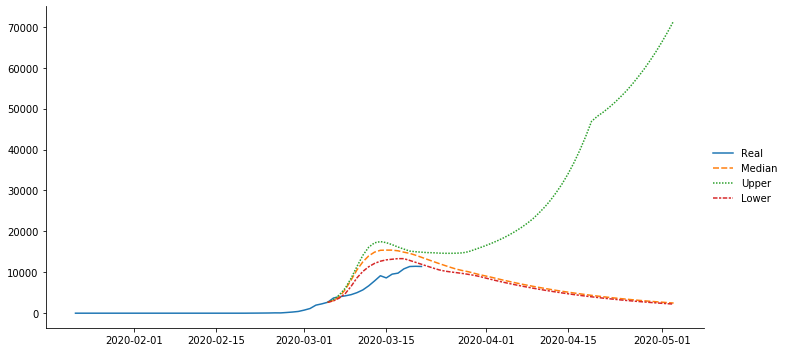

In [152]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Iran')

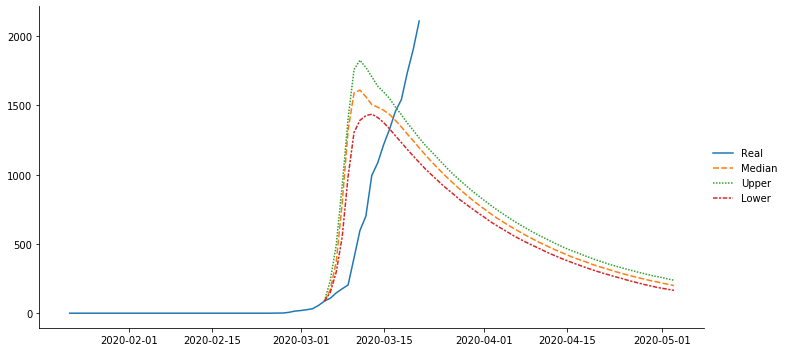

In [153]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Norway')

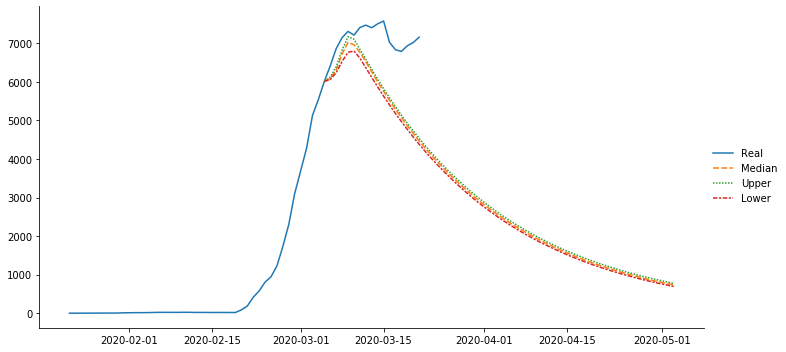

In [154]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Korea, South')

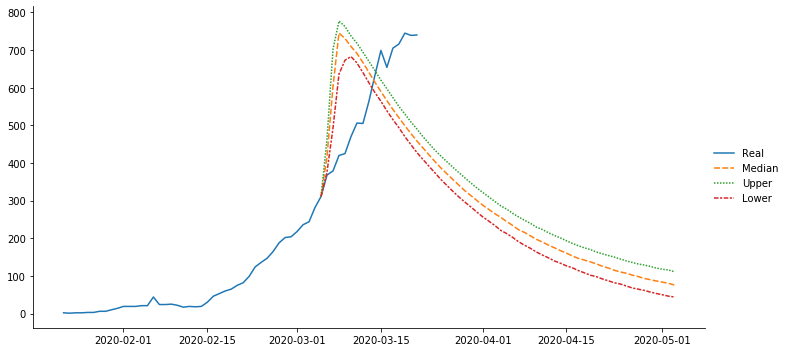

In [155]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Japan')

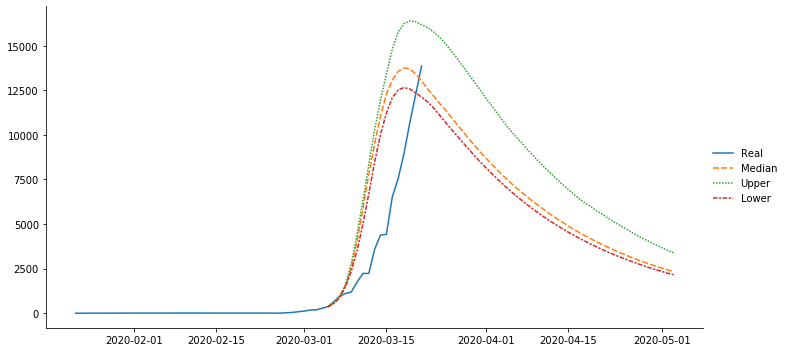

In [156]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'France')

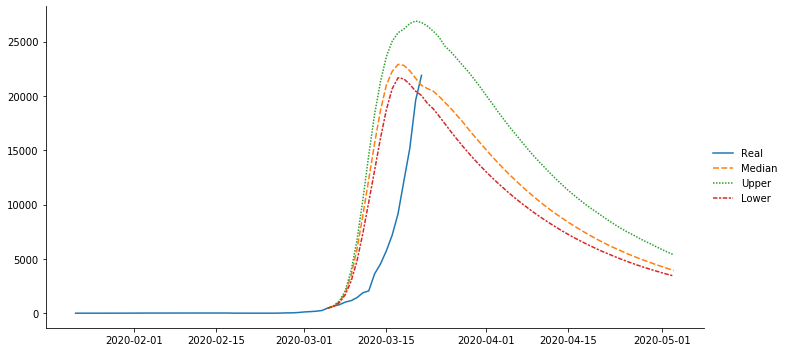

In [157]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'Germany')

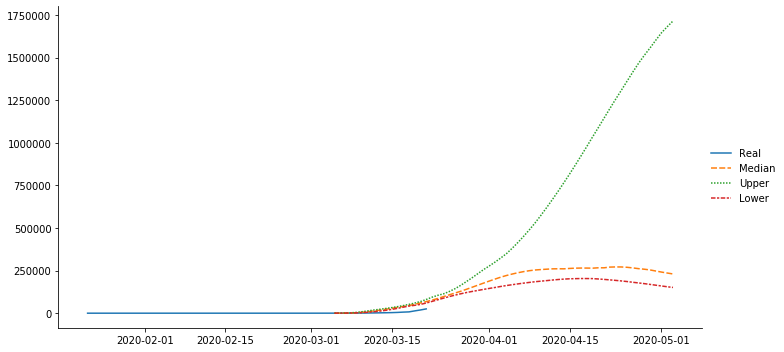

In [158]:
draw_infected(fit, pd.to_datetime('2020-03-05'), 60, 'US')

In [159]:
### Prediction ###

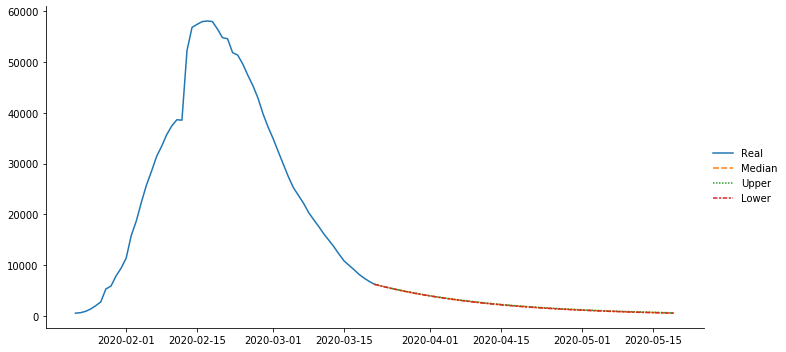

In [161]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'China')

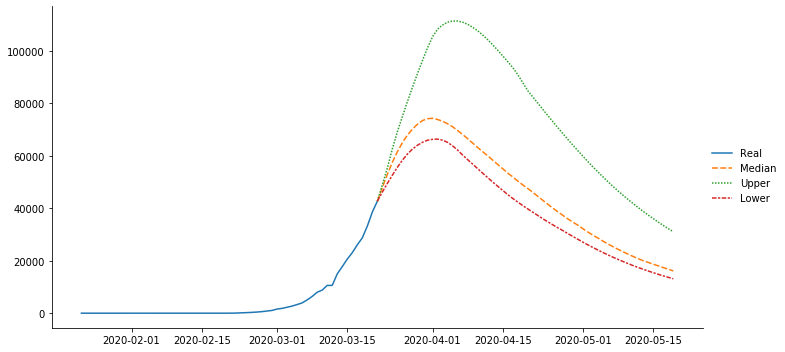

In [162]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Italy')

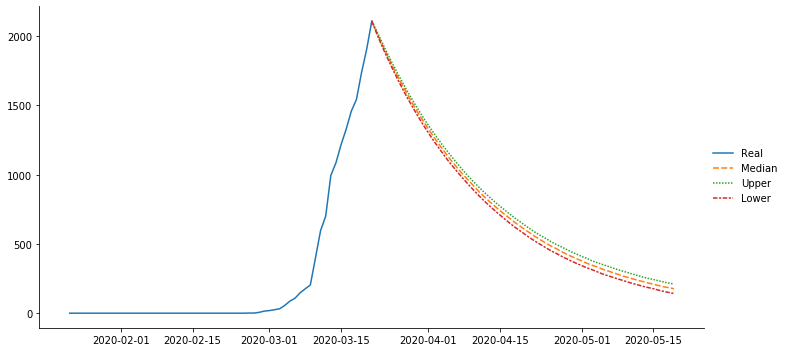

In [163]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Norway')

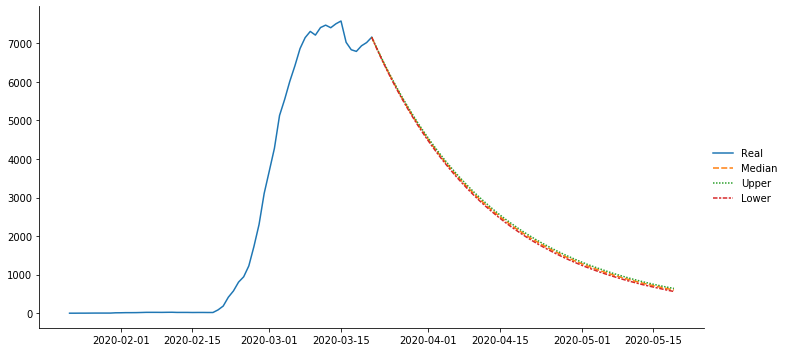

In [164]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Korea, South')

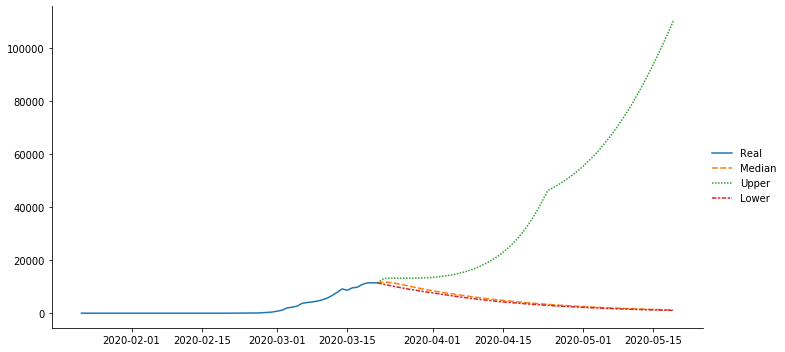

In [165]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Iran')

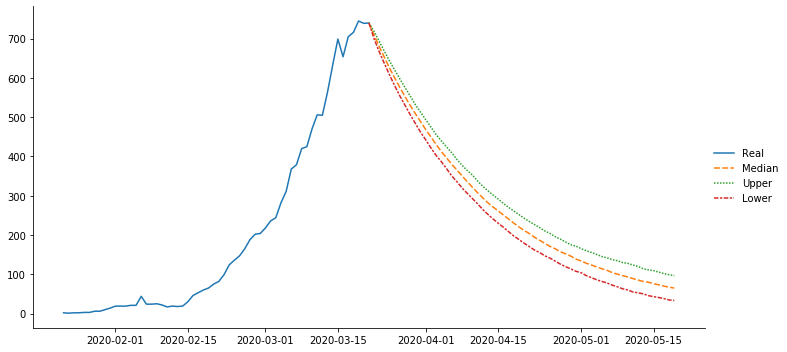

In [166]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Japan')

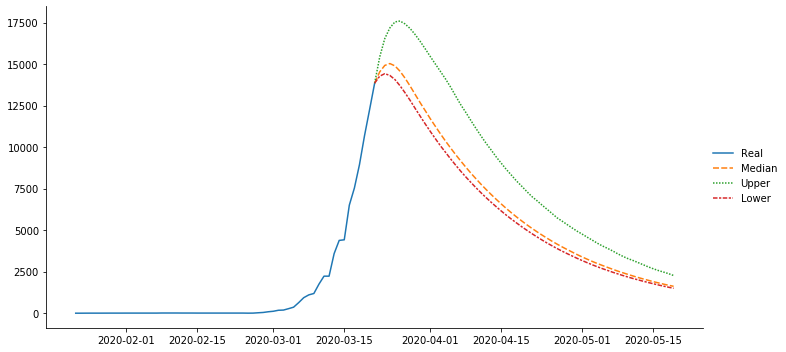

In [167]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'France')

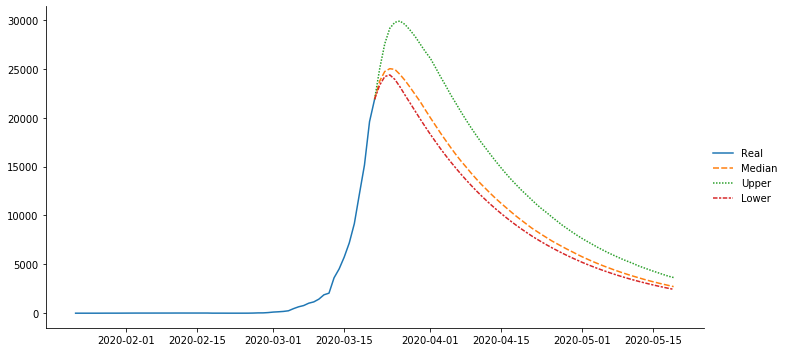

In [168]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Germany')

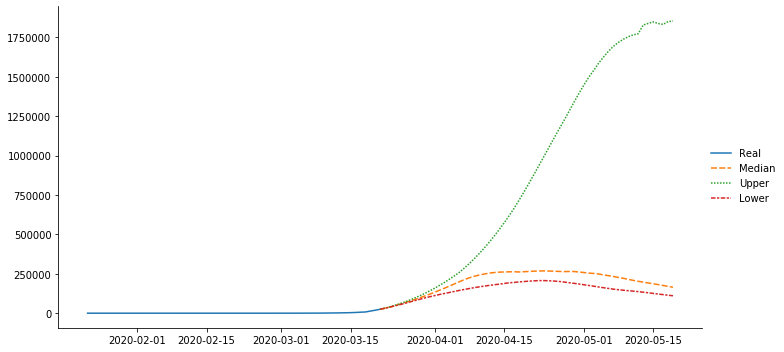

In [169]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'US')

In [170]:
def draw_infected_world(fit, start, horizen):
    a = fit['a']
    p = fit['p']
    c = fit['c']
    sigma_S = fit['sigma_S']
    sigma_R = fit['sigma_R']
    np.random.shuffle(a)
    np.random.shuffle(p)
    np.random.shuffle(c)
    np.random.shuffle(sigma_S)
    np.random.shuffle(sigma_R)
    data = pd.DataFrame()
    for i in range(a.shape[0]):
        infected = simulate(a[i], p[i], c[i], sigma_S[i], sigma_R[i], start, horizen)
        data = pd.concat([data, infected.sum(axis=1)], axis=1)
    graph = pd.DataFrame(index=pd.date_range('2020-01-22', start + pd.Timedelta(days=horizen)))
    real = (confirmed - removed).sum(axis=1)
    median = data.median(axis=1)
    upper = data.quantile(q=0.75, axis=1)
    lower = data.quantile(q=0.25, axis=1)
    graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", ci='sd', data=graph, aspect=2);

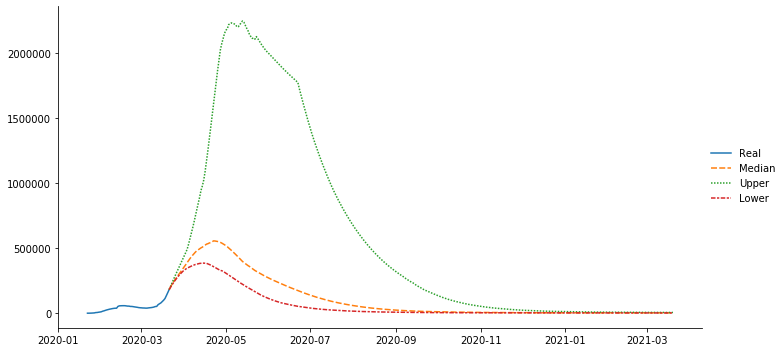

In [171]:
draw_infected_world(fit, pd.to_datetime('2020-03-21'), 365)

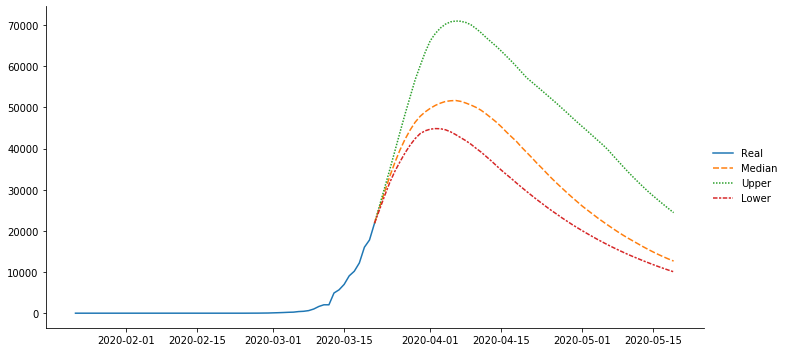

In [172]:
draw_infected(fit, pd.to_datetime('2020-03-21'), 60, 'Spain')

In [128]:
confirmed.columns

Index(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'China',
       'Denmark', 'France', 'Germany', 'Iran', 'Italy', 'Japan',
       'Korea, South', 'Malaysia', 'Netherlands', 'Norway', 'Portugal',
       'Spain', 'Sweden', 'Switzerland', 'US', 'United Kingdom'],
      dtype='object', name='Country/Region')